In [1]:
import cv2
import ast
import numpy as np
import matplotlib.pyplot as plt

from metrics.BoundingBox import BoundingBox
from metrics.BoundingBoxes import BoundingBoxes
from metrics.Evaluator import Evaluator
from metrics.utils import BBFormat, BBType

In [2]:
def getBoxesIntersect(boxA, boxB):
        if boxA[0] > boxB[2]:
            return False  # boxA is right of boxB
        if boxB[0] > boxA[2]:
            return False  # boxA is left of boxB
        if boxA[3] < boxB[1]:
            return False  # boxA is above boxB
        if boxA[1] > boxB[3]:
            return False  # boxA is below boxB
        return True

def getIntersectionArea(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # intersection area
    return (xB - xA + 1) * (yB - yA + 1)

def getUnionAreas(boxA, boxB, interArea=None):
    area_A = getArea(boxA)
    area_B = getArea(boxB)
    if interArea is None:
        interArea = getIntersectionArea(boxA, boxB)
    return float(area_A + area_B - interArea)

def getArea(box):
    return (box[2] - box[0] + 1) * (box[3] - box[1] + 1)

def get_iou(boxA, boxB):
    if getBoxesIntersect(boxA, boxB) is False:
        return 0
    interArea = getIntersectionArea(boxA, boxB)
    union = getUnionAreas(boxA, boxB, interArea=interArea)
    iou = interArea / union
    assert iou >= 0
    return iou

In [3]:
IOUThreshold = 0.5

def get_iou_info(pred_bboxes, gt_bboxes):
    # Get only detection of class c
    dects = pred_bboxes
    FP_boxes = []
    
    iou_sum = 0
    TP = 0
    gt_usablecheck = [True] * len(gt_bboxes)
    for d in range(len(dects)):
        gt = gt_bboxes
        iouMax = 0
        for j in range(len(gt)):
            iou = get_iou(dects[d], gt[j])
            if iou > iouMax:
                iouMax = iou
                jmax = j

        if iouMax >= IOUThreshold:
            if gt_usablecheck[jmax]:
                gt_usablecheck[jmax] = False
                iou_sum += iouMax
                TP += 1
            else:
                FP_boxes.append(dects[d])
        else:
            FP_boxes.append(dects[d])
        
    num = len(pred_bboxes) + len(gt_bboxes) - TP
    return (iou_sum, num, TP, FP_boxes)

In [4]:
CONF_THRESHOLD = 0.3

In [5]:
def get_det_info(model_name, mixed_image_name):
    det_log = './runs/detect/'+model_name+'/labels/'+mixed_image_name+'.txt'
    with open(det_log, 'r') as f:
        lines = f.readlines()
    boxes, confs, classes = ([], [], [])
    for line in lines:
        r = line.rsplit()
        r = [float(e) for e in r]
        # cx cy w h to ltrb
        p = r[1:5]
        p = [p[0]-p[2]/2, p[1]-p[3]/2, p[0]+p[2]/2, p[1]+p[3]/2]
        p = [int(e * 800) for e in p]
        if r[5] > CONF_THRESHOLD:
            boxes.append(p)
            confs.append(r[5])
            classes.append(int(r[0]))
    return (boxes, confs, classes)

In [6]:
def get_gt_info(mixed_image_name, rot_flag=False):
    gt_log = '../coco_mixed_yolov5/size50to150/val/labels/'+mixed_image_name+'.txt'
    if rot_flag:
        gt_log = '../coco_mixed_yolov5/size50to150_rot/val/labels/'+mixed_image_name+'.txt'
    with open(gt_log, 'r') as f:
        gts = f.readlines()
    gt_bboxes = []
    for i in range(len(gts)):
        line = gts[i]
        r = line.rsplit()
        r = [float(e) for e in r]
        p = r[1:5]
        p = [p[0]-p[2]/2, p[1]-p[3]/2, p[0]+p[2]/2, p[1]+p[3]/2]
        p = [int(e * 800) for e in p]
        gt_bboxes.append(p)
    return gt_bboxes

In [7]:
mixed_image_names = ['mix' + "{number:06}".format(number=e) for e in range(54)]
# model_names = ['v5l6_fp16_tflite', 'v5l6_int8_tflite', 'yolov5l6_fp16_tflite', 'exp2', 'yolov5l6-int8-int-data']
model_names = ['yolov5l6_fp16_tflite', 'yolov5l6_fp16_rot_tflite', 'yolov5l6-int8-int-data']

In [8]:
det_dict = {}
gt_dict = {}
rot_gt_dict = {}
pred_dict = {}

for mixed_image_name in mixed_image_names:
    for model_name in model_names:
        det_key = model_name + '_' + mixed_image_name
        det_dict[det_key] = get_det_info(model_name, mixed_image_name)
    gt_dict[mixed_image_name] = get_gt_info(mixed_image_name)
    
for mixed_image_name in mixed_image_names:
    rot_gt_dict[mixed_image_name] = get_gt_info(mixed_image_name, rot_flag=True)
    
for mixed_image_name in mixed_image_names:
    for model_name in model_names:
        pred_bboxes = []
        key = model_name + '_' + mixed_image_name
        boxes, confs, classes = det_dict[key]
        for b, conf, c in zip(boxes, confs, classes):
            if int(c) == 0:
                # c1 c2 c3
                b += [conf]
                pred_bboxes.append(b)
        pred_dict[key] = pred_bboxes

In [9]:
def format_bboxes(key, dbs, cnfs, bbtype):
    boundingBoxes = BoundingBoxes()
    for i in range(len(dbs)):
        cnf = cnfs[i] if cnfs is not None else 1
        boundingBoxes.addBoundingBox(BoundingBox(
            key, 0,
            dbs[i][0],
            dbs[i][1],
            dbs[i][2],
            dbs[i][3],
            bbType=bbtype,
            classConfidence=cnf,
            format=BBFormat.XYX2Y2
        ))
    return boundingBoxes

In [10]:
def get_formatted_det_bboxes(model_name, mixed_image_name):
    boxes, confs, classes = det_dict[model_name+'_'+mixed_image_name]
    dbs = []
    cnfs = []
    for i in range(len(classes)):
        if classes[i] == 0:
            dbs.append(boxes[i])
            cnfs.append(confs[i])
    return format_bboxes(model_name+'_'+mixed_image_name, dbs, cnfs, BBType.Detected)

In [11]:
def get_formatted_gt_bboxes(model_name, mixed_image_name):
    if 'rot' not in model_name:
        dbs = gt_dict[mixed_image_name]
    else:
        dbs = rot_gt_dict[mixed_image_name]
    return format_bboxes(model_name+'_'+mixed_image_name, dbs, None, BBType.GroundTruth)

In [12]:
def get_info(model_name, mixed_image_name, conf_threshold=0.3):
    pred_bboxes = pred_dict[model_name+'_'+mixed_image_name]
    pred_bboxes = [pb for pb in pred_bboxes if pb[4] >= conf_threshold]
    gt_bboxes = gt_dict[mixed_image_name]
    iou_sum, num, TP, FP_boxes = get_iou_info(pred_bboxes, gt_bboxes)
    return (iou_sum, num, TP, len(gt_bboxes), pred_bboxes, FP_boxes)

In [13]:
def get_miou(model_name, mixed_image_name, conf_threshold=0):
    iou_sum, num, TP, gt_len, pred_bboxes, fp_boxes = get_info(model_name, mixed_image_name, conf_threshold)
    return iou_sum/num

In [14]:
def visualize_conf_distribution(tp, fp):
    tp_confs = np.array(tp)[:,4]
    fp_confs = np.array(fp)[:,4]
    x1 = np.arange(0, len(tp_confs))
    x2 = np.arange(0, len(fp_confs))
    plt.hist(tp_confs, bins=30, alpha=0.85, label='tp_conf')
    plt.hist(fp_confs, bins=30, alpha=0.85, label='fp_conf')
    plt.legend()
    plt.show()

# Check and get the best confidence threshold (TBD)

In [18]:
# model_names = ['ckpt_0101']
# mixed_image_names = ['mix000000']
for model_name in model_names:
    model_miou_sum = 0
    for mixed_image_name in mixed_image_names:
        _, _, _, _, _, fps = get_info(model_name, mixed_image_name, 0)
        fp_confs = np.array(fps)[:,4]
        max_miou = 0
        max_conf_thres = 0
        for fp_conf in fp_confs:
            miou = get_miou(model_name, mixed_image_name, fp_conf)
            if max_miou < miou:
                max_miou = miou
                max_conf_thres = fp_conf
        print(max_miou, max_conf_thres)

0.37976070073214385 0.326095
0.5233474664980607 0.34551
0.46585488021204735 0.304386
0.2937049776649402 0.31117
0.4003673710625765 0.343474
0.37284548627758124 0.309071
0.501404445214621 0.321167
0.44201408134921266 0.342022
0.26738567042723227 0.306492
0.4202849780802402 0.312671


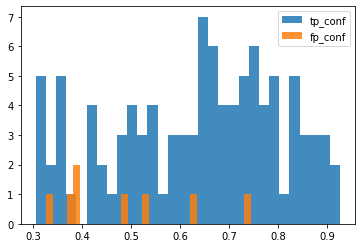

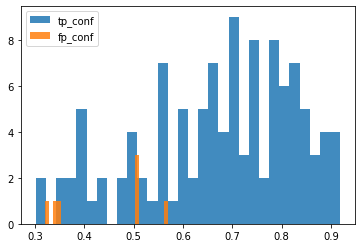

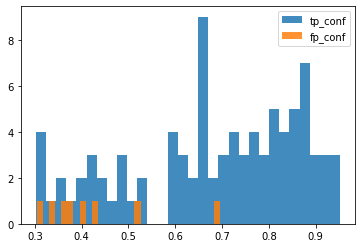

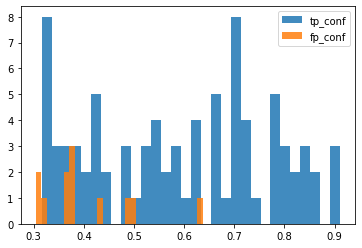

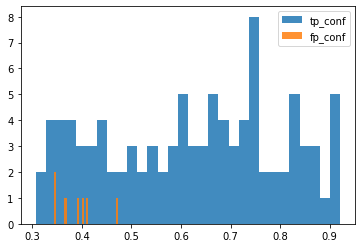

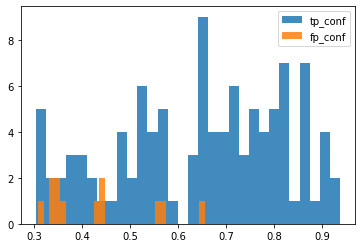

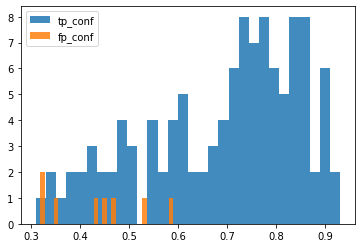

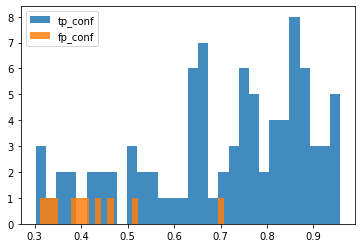

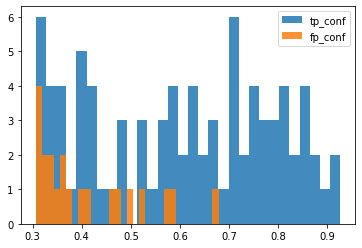

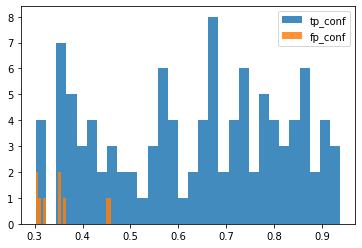

['yolov5l6_fp16_tflite', 0.4209339875200482]
['yolov5l6-int8-int-data', 0.40541228096183185]


In [19]:
# mixed_image_names = ['mix000000', 'mix000001', 'mix000002', 'mix000003', 'mix000004']
# model_names = ['ckpt_0000_1', 'ckpt_0001_1', 'ckpt_00005', 'ckpt_0101_1', 'ckpt_0101',  
#               'ckpt_0303_1', 'ckpt_0303', 'ckpt_0307', 'ckpt_0703', 'ckpt_1010', 'default']
# model_names = ['ckpt_0101']
model_miou_list = []
for model_name in model_names:
    model_miou_sum = 0
    for mixed_image_name in mixed_image_names:
        iou_sum, num, TP, gt_len, pred_bboxes, fp_boxes = get_info(model_name, mixed_image_name)
        miou = iou_sum/num
        model_miou_sum += miou
        tp = [p for p in pred_bboxes if p not in fp_boxes]
        visualize_conf_distribution(tp, fp_boxes)
    model_miou_list.append([model_name, model_miou_sum/len(mixed_image_names)])
model_miou_list = sorted(model_miou_list, key=lambda x: x[1], reverse=True)
for mm in model_miou_list:
    print(mm)

# Calculate mIoU

In [84]:
# model_miou_list = []
# for model_name in model_names:
#     model_miou_sum = 0
#     for mixed_image_name in mixed_image_names:
#         iou_sum, num, TP, gt_len, pred_bboxes, fp_boxes = get_info(model_name, mixed_image_name)
#         miou = iou_sum/num
#         model_miou_sum += miou
#     model_miou_list.append([model_name, model_miou_sum/len(mixed_image_names)])
# model_miou_list = sorted(model_miou_list, key=lambda x: x[1], reverse=True)
# for mm in model_miou_list:
#     print(mm)

# Use Pascal VOC Metrics for mIoU

In [15]:
evaluator = Evaluator()

model_miou_list = []
for model_name in model_names:
    allBoundingBoxes = BoundingBoxes()
    for mixed_image_name in mixed_image_names:
        boundingBoxes = BoundingBoxes()
        det = get_formatted_det_bboxes(model_name, mixed_image_name)
        boundingBoxes.concatBoundingBoxes(det)
        allBoundingBoxes.concatBoundingBoxes(det)
        gt = get_formatted_gt_bboxes(model_name, mixed_image_name)
        boundingBoxes.concatBoundingBoxes(gt)
        allBoundingBoxes.concatBoundingBoxes(gt)
        #print(model_name, mixed_image_name, evaluator.GetPascalVOCMetrics(boundingBoxes)[0]['AP'])
    print(model_name, evaluator.GetPascalVOCMetrics(allBoundingBoxes)[0]['AP'])

yolov5l6_fp16_tflite 0.5548389838853873
yolov5l6_fp16_rot_tflite 0.41178404217274467
yolov5l6-int8-int-data 0.5642692396089694


# Check characteristics of fp and int quantization

In [27]:
def draw_size_miou_conf(smc):
    sizes = np.array(smc)[:,0]
    mious = np.array(smc)[:,1]
    confs = np.array(smc)[:,2]
    plt.scatter(sizes, mious, marker='o', c='red', s=2)
    plt.title('Box Size to mIoU')
    plt.xlabel('Box Size (Area)')
    plt.show()
    plt.clf()
    plt.scatter(sizes, confs, marker='o', c='green', s=2)
    plt.title('Box Size to Confidence')
    plt.xlabel('Box Size (Area)')
    plt.show()
    plt.clf()

yolov5l6_fp16_tflite 0.5548389838853873


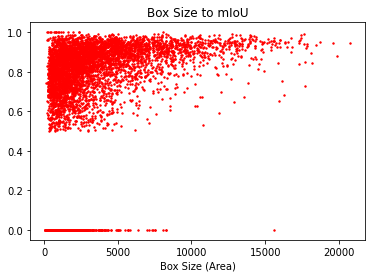

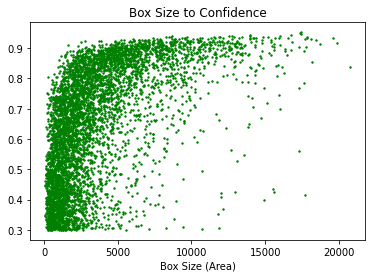

TP conf 0.6679785210219272
FP conf 0.4483151084112149 

yolov5l6-int8-int-data 0.5642692396089694


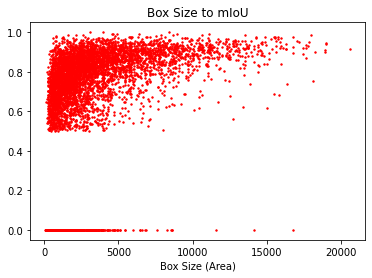

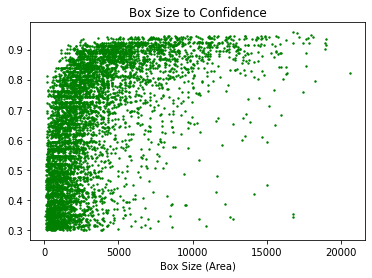

TP conf 0.6835293763250885
FP conf 0.45291321391076117 



<Figure size 432x288 with 0 Axes>

In [34]:
evaluator = Evaluator()

model_miou_list = []
for model_name in model_names:
    allBoundingBoxes = BoundingBoxes()
    for mixed_image_name in mixed_image_names:
        boundingBoxes = BoundingBoxes()
        det = get_formatted_det_bboxes(model_name, mixed_image_name)
        boundingBoxes.concatBoundingBoxes(det)
        allBoundingBoxes.concatBoundingBoxes(det)
        gt = get_formatted_gt_bboxes(model_name, mixed_image_name)
        boundingBoxes.concatBoundingBoxes(gt)
        allBoundingBoxes.concatBoundingBoxes(gt)
        #print(model_name, mixed_image_name, evaluator.GetPascalVOCMetrics(boundingBoxes)[0]['AP'])
    r = evaluator.GetPascalVOCMetrics(allBoundingBoxes)[0]
    print(model_name, r['AP'])
    size_miou_conf = r['size miou conf']
    draw_size_miou_conf(size_miou_conf)
    print('TP conf', r['TP conf'])
    print('FP conf', r['FP conf'], '\n')

# Check Prediction bboxes

In [16]:
def draw_bbox(image, bboxes, linecolor=(255, 0, 0)):
    for b in bboxes:
        c1, c2 = (b[0], b[1]), (b[2], b[3])
        cv2.rectangle(image, c1, c2, linecolor, 2)
    return image

In [17]:
def visualize(model_name, mixed_image_name):
    
    boundingBoxes = BoundingBoxes()
    det = get_formatted_det_bboxes(model_name, mixed_image_name)
    boundingBoxes.concatBoundingBoxes(det)
    gt = get_formatted_gt_bboxes(model_name, mixed_image_name)
    boundingBoxes.concatBoundingBoxes(gt)
    
    _, num, TP, gt_len, pred_bboxes, fp_boxes = get_info(model_name, mixed_image_name)

    if 'rot' not in model_name:
        original_image = cv2.imread('../coco_mixed_yolov5/size50to150/val/images/'+mixed_image_name+'.png')
    else:
        original_image = cv2.imread('../coco_mixed_yolov5/size50to150_rot/val/images/'+mixed_image_name+'.png')
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    image = draw_bbox(original_image, pred_bboxes)
    image = draw_bbox(image, fp_boxes, (0, 255, 0))

    plt.figure(figsize=(12,12))
    plt.title(model_name+' '+mixed_image_name)
    plt.imshow(image)
    plt.show()
    
    print(model_name, mixed_image_name)
    print('pd_boxes',len(pred_bboxes))
    print('gt_boxes',gt_len)
    print('TP',TP)
    print('FP',len(fp_boxes))
    print('num',num)
    print('fp_boxes', fp_boxes)
    print('miou',model_name, mixed_image_name, evaluator.GetPascalVOCMetrics(boundingBoxes)[0]['AP']) 

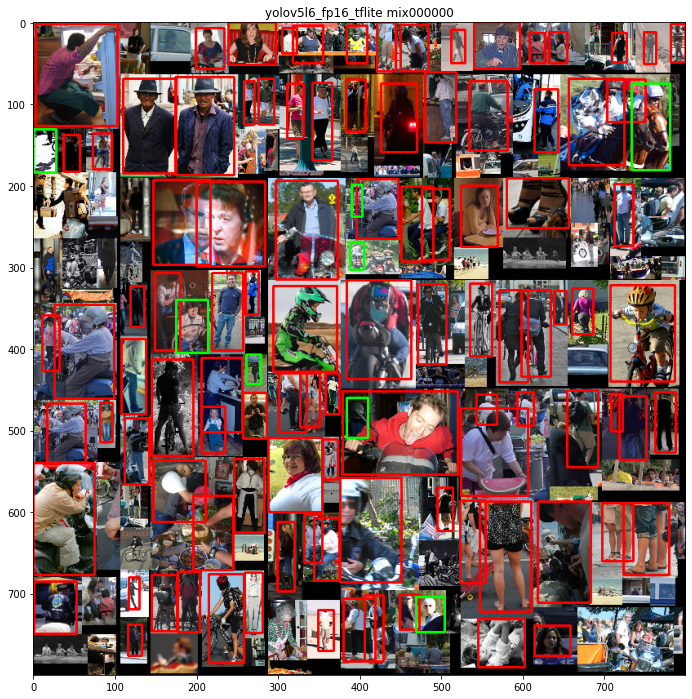

yolov5l6_fp16_tflite mix000000
pd_boxes 110
gt_boxes 203
TP 102
FP 8
num 211
fp_boxes [[384, 460, 410, 509, 0.326095], [390, 199, 403, 238, 0.374759], [261, 407, 279, 443, 0.390913], [733, 75, 780, 181, 0.391737], [0, 131, 28, 184, 0.485822], [388, 270, 405, 303, 0.533186], [469, 704, 504, 747, 0.631249], [175, 340, 214, 405, 0.744642]]
miou yolov5l6_fp16_tflite mix000000 0.4905761774015658


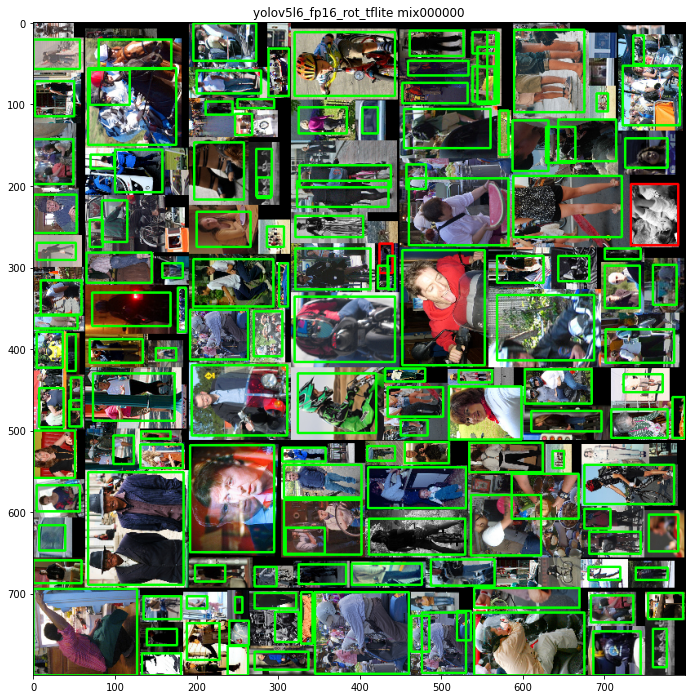

yolov5l6_fp16_rot_tflite mix000000
pd_boxes 148
gt_boxes 203
TP 2
FP 146
num 349
fp_boxes [[247, 112, 268, 138, 0.307718], [450, 487, 483, 506, 0.314407], [274, 190, 291, 215, 0.317983], [271, 771, 337, 793, 0.326686], [67, 56, 175, 150, 0.34382], [70, 162, 99, 179, 0.347802], [326, 175, 438, 202, 0.354635], [69, 58, 118, 101, 0.356414], [250, 94, 295, 105, 0.362683], [463, 727, 485, 771, 0.364639], [556, 13, 570, 99, 0.371894], [46, 435, 59, 474, 0.388102], [675, 596, 707, 620, 0.397422], [735, 16, 748, 51, 0.40011], [628, 128, 664, 172, 0.400985], [636, 525, 650, 546, 0.405843], [434, 286, 443, 327, 0.408167], [457, 174, 481, 204, 0.41101], [722, 53, 792, 126, 0.429611], [309, 619, 357, 651, 0.431008], [247, 704, 256, 723, 0.436286], [759, 743, 776, 790, 0.439879], [198, 665, 235, 685, 0.442294], [521, 426, 562, 441, 0.45603], [270, 354, 305, 409, 0.465438], [538, 12, 567, 38, 0.474924], [296, 722, 325, 759, 0.476706], [69, 242, 85, 275, 0.4866], [132, 501, 168, 510, 0.489211], [271,

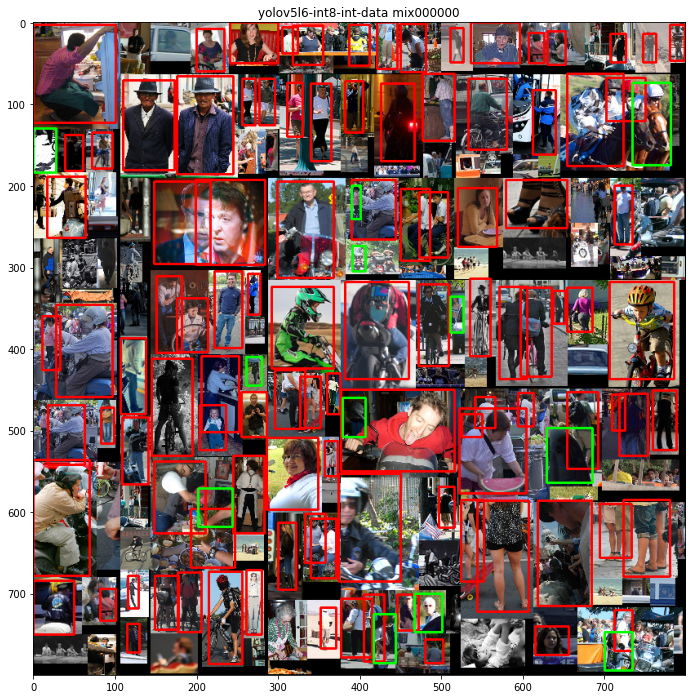

yolov5l6-int8-int-data mix000000
pd_boxes 118
gt_boxes 203
TP 106
FP 12
num 215
fp_boxes [[417, 725, 444, 785, 0.309071], [629, 497, 685, 564, 0.335472], [511, 336, 527, 380, 0.343413], [202, 571, 244, 618, 0.346193], [700, 747, 734, 794, 0.355153], [379, 460, 407, 508, 0.358088], [261, 410, 280, 445, 0.426184], [734, 74, 781, 175, 0.438295], [390, 200, 401, 241, 0.443795], [391, 274, 407, 305, 0.554064], [0, 130, 28, 184, 0.574764], [467, 700, 501, 747, 0.656609]]
miou yolov5l6-int8-int-data mix000000 0.5114652446539079


In [18]:
selected_models = ['yolov5l6_fp16_tflite', 'yolov5l6_fp16_rot_tflite', 'yolov5l6-int8-int-data']
mixed_image_name = 'mix000000'
for model_name in selected_models:
    visualize(model_name, mixed_image_name)

In [20]:
def get_gt_bboxes(mixed_image_name):
    size_key = 'size50to150'
    gt_log = './data/dataset/coco_mixed_val.txt'
    with open(gt_log, 'r') as f:
        gts = f.readlines()
    for i in range(len(gts)):
        line = gts[i]
        if size_key in line and mixed_image_name in line:
            gt_bboxes = line.rsplit()[1:]
            gt_bboxes = [[int(e) for e in gt_bbox.split(',')] for gt_bbox in gt_bboxes]
    return gt_bboxes

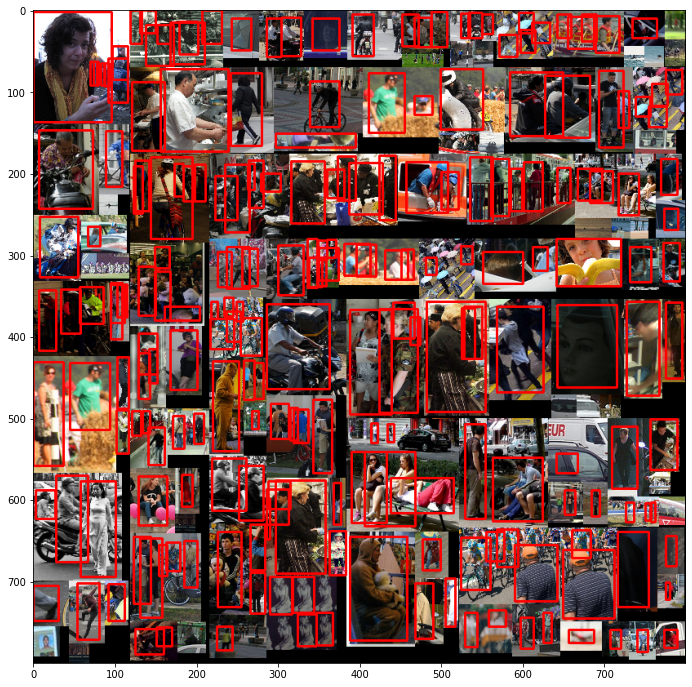

In [30]:
original_image = cv2.imread('./data/mixed_images/'+mixed_image_name+'.png')
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
gt_bboxes = get_gt_bboxes(mixed_image_name)
image = draw_bbox(original_image, gt_bboxes)
plt.figure(figsize=(12,12))
plt.imshow(image)